In [78]:
import numpy as np
import baseline_model
from casadi import *
import do_mpc
import decentralized as dec
import util
import sim_drone_main
from baseline_model import baseline_drone_model
from baseline_model_mpc import baseline_drone_mpc
from baseline_model_simulator import baseline_drone_simulator
import itertools

In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
Q = np.eye(6)
R = np.eye(3)
n_agents = 3
n_inputs = 3
n_states = 6
Qf = Q*1e3

In [97]:
Qs = [Q] * n_agents
Rs = [R] * n_agents
Qfs = [Qf] * n_agents

In [98]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

x = model.set_variable(var_type='_x', var_name='x', shape=(6, 1))
u = model.set_variable(var_type='_u', var_name='u', shape=(3, 1))
print(f'Shape of x is {x.shape}')
print(f'Shape of u is {u.shape}')
#x = p_x,p_y,p_z,v_x,v_y,v_z
#u = theta, phi, tau
g = 9.81
model.set_rhs('x', vertcat(x[3], x[4], x[5], g*np.tan(u[0]), -g*np.tan(u[1]), u[2]-g))

Shape of x is (6, 1)
Shape of u is (3, 1)


In [99]:
theta_max = np.pi/6
phi_max = np.pi/6
tau_max = 5
v_max = 5

x_dims = [6,6,6]

Q = np.eye(n_states)*10
Qf = np.eye(n_states)*1e3
R = np.eye(n_inputs)

radius = 0.5
n_dims = [3,3,3]
episode=200
x_baseline_init, x_baseline_f = util.paper_setup_3_quads() 
#concatenated initial and final states of all 3 agents

x_baseline1 = x_baseline_init

states_list = np.zeros((episode+1,9)) #positions of each drone
states_list[0,:] = np.array([x_baseline1[0],x_baseline1[1],x_baseline1[2],\
                        x_baseline1[6],x_baseline1[7],x_baseline1[8],\
                        x_baseline1[12],x_baseline1[13],x_baseline1[14]]).flatten()

In [100]:
baseline_drone_model(dec.split_agents(x_baseline_f.reshape(1,-1),x_dims)[0].flatten(), Q, R, Qf,x_baseline1,x_dims)

In [101]:
model_baseline = [baseline_drone_model(dec.split_agents(x_baseline_f.reshape(1,-1),x_dims)[i].flatten(), Q, R, Qf, x_baseline1, x_dims) for i in range(n_agents)]

In [102]:
mpc_baseline = [baseline_drone_mpc(model_i,n_agents,x_baseline1,x_dims, v_max, theta_max, phi_max, tau_max) for model_i in model_baseline]

In [103]:
simulator_baseline = [baseline_drone_simulator(model_i) for model_i in model_baseline]

In [104]:
dec.split_agents(x_baseline1.reshape(1,-1),x_dims)[0]

array([[0.479, 1.497, 1.012, 0.   , 0.   , 0.   ]])

In [105]:
simulator_baseline

In [106]:
split_states = dec.split_agents(x_baseline1.reshape(1,-1),x_dims)
for m in range(len(simulator_baseline)):
        simulator_baseline[m].x0['x'] = split_states[m].T #dimension mismatch here?
        mpc_baseline[m].x0 = split_states[m].T

In [107]:
u_init_baseline = np.full((n_agents*n_inputs,1), 0.0)
u_dims = [3,3,3]

In [108]:
split_inputs = dec.split_agents(u_init_baseline.reshape(1,-1),u_dims)
split_inputs

[array([[0., 0., 0.]]), array([[0., 0., 0.]]), array([[0., 0., 0.]])]

In [109]:
for m in range(len(mpc_baseline)):
    print(split_inputs[m].T.shape)

(3, 1)
(3, 1)
(3, 1)


In [110]:
u0_baseline = []
x_baseline_next = []
for m in range(len(mpc_baseline)):
    mpc_baseline[m].u0 = split_inputs[m].T
    simulator_baseline[m].u0 = split_inputs[m].T
    mpc_baseline[m].set_initial_guess()
    u0_baseline.append(mpc_baseline[m].make_step(split_states[m].T))
    x_baseline_next.append(simulator_baseline[m].make_step(split_inputs[m].T))

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      666
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       51

Total number of variables............................:      267
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Total number of equality constraints.................:      216
Total number of inequality constraints...............:       15
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       15

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1983828e+03 4.91e-01 1.36e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [111]:
[mpc_baseline[i].data._lam_g_num for i in range(len(mpc_baseline))][0]

array([[ 3.319e+03,  8.338e+00,  1.220e+03,  7.786e+02,  4.729e-01,
         5.514e+03, -2.459e+03, -5.986e+00, -9.152e+02, -5.430e+02,
        -2.549e-01, -4.120e+03, -8.198e+02, -1.995e+00, -3.051e+02,
        -1.537e+02, -1.846e-02, -1.363e+03,  3.279e+03,  7.982e+00,
         1.220e+03,  6.147e+02,  7.386e-02,  5.453e+03, -2.459e+03,
        -5.986e+00, -9.152e+02, -4.200e+02,  4.438e-02, -4.074e+03,
        -8.198e+02, -1.995e+00, -3.051e+02, -1.127e+02,  8.131e-02,
        -1.348e+03,  3.279e+03,  7.982e+00,  1.220e+03,  4.507e+02,
        -3.252e-01,  5.392e+03, -3.279e+03, -7.982e+00, -1.220e+03,
        -4.507e+02,  3.252e-01, -5.392e+03,  1.002e+01,  1.002e+01,
         1.002e+01, -2.430e+03, -5.746e+00, -9.148e+02, -3.060e+02,
        -1.943e-01, -4.021e+03, -8.099e+02, -1.915e+00, -3.049e+02,
        -7.502e+01, -9.322e-04, -1.330e+03,  3.240e+03,  7.661e+00,
         1.220e+03,  3.001e+02,  3.729e-03,  5.321e+03, -2.430e+03,
        -5.746e+00, -9.148e+02, -1.846e+02,  9.2

In [112]:
theta_max = np.pi/6
phi_max = np.pi/6
tau_max = 5
v_max = 5

x_dims = [n_states]*n_agents
u_dims = [n_inputs]*n_agents

Q = np.eye(n_states)*10
Qf = np.eye(n_states)*1e3
R = np.eye(n_inputs)

radius = 0.5
n_dims = [3,3,3]
episode= 200
x_baseline_init, x_baseline_f = util.paper_setup_3_quads()

x_baseline1 = x_baseline_init #concatenated states of all agents

states_list = np.zeros((episode+1,3*n_agents)) #positions of each drone
states_list[0,:] = np.array([x_baseline1[0],x_baseline1[1],x_baseline1[2],\
                        x_baseline1[6],x_baseline1[7],x_baseline1[8],\
                        x_baseline1[12],x_baseline1[13],x_baseline1[14]]).flatten()

In [113]:
n_agents = 3
n_states = 6
n_inputs = 3

def setup_baseline(x_baseline, x_baseline_f, v_max, theta_max, phi_max, tau_max,\
                    x_dims, u_dims, Q, R, Qf, n_agents, n_dims, radius):
    model_baseline = [baseline_drone_model(dec.split_agents(x_baseline_f.reshape(1,-1),x_dims)[i].flatten(), Q, \
                     R, Qf, x_baseline, x_dims) for i in range(n_agents)] 
    #a list of baseline models for each agent
    
    mpc_baseline = [baseline_drone_mpc(model_i,n_agents,x_baseline, x_dims, v_max, theta_max, phi_max,\
                   tau_max) for model_i in model_baseline]
    #a list of baseline mpc controllers for each agent
    
    simulator_baseline = [baseline_drone_simulator(model_i) for model_i in model_baseline]
    
    #splitting the states of each agent
    split_states = dec.split_agents(x_baseline.reshape(1,-1),x_dims)

    for m in range(len(simulator_baseline)):
        
        simulator_baseline[m].x0['x'] = split_states[m].T #dimension mismatch here?
        mpc_baseline[m].x0 = split_states[m].T

    u_init_baseline = np.full((n_agents*n_inputs,1), 0.0)
    split_inputs = dec.split_agents(u_init_baseline.reshape(1,-1),u_dims)
    
    u0_baseline = []
    x_baseline_next = []
    for m in range(len(mpc_baseline)):
        mpc_baseline[m].u0 = split_inputs[m].T
        simulator_baseline[m].u0 = split_inputs[m].T
        mpc_baseline[m].set_initial_guess()
        u0_baseline.append(mpc_baseline[m].make_step(split_states[m].T))
        x_baseline_next.append(simulator_baseline[m].make_step(split_inputs[m].T))

    return u0_baseline, x_baseline_next, [mpc_baseline[i].data._lam_g_num for i in range(len(mpc_baseline))]
    #last _lam_g_num is the Lagrange multiplier

In [114]:
import concurrent.futures
import time

In [115]:
episode=5

In [116]:
states_list = np.zeros((episode+1,3*n_agents)) #positions of each drone
states_list[0,:] = np.array([x_baseline1[0],x_baseline1[1],x_baseline1[2],\
                        x_baseline1[6],x_baseline1[7],x_baseline1[8],\
                        x_baseline1[12],x_baseline1[13],x_baseline1[14]]).flatten()


In [117]:
states_list.shape

(6, 9)

In [144]:
time_start = time.perf_counter()
results = []

with concurrent.futures.ProcessPoolExecutor(100) as executor:
# with concurrent.futures.ThreadPoolExecutor(10) as executor:
    for k in range(episode):
        f = executor.submit(setup_baseline,x_baseline1, x_baseline_f, v_max, theta_max, phi_max, tau_max,\
                    x_dims, u_dims, Q, R, Qf, n_agents, n_dims, radius)
        """
        TODO:separate the states of each agent from f.result()
        """
        results.append(f)
        
        for m in range(n_agents):
            states_list[k,m*3:(m+1)*3] = f.result()[1][m][0:3].flatten() #this refers to the pos vector of agent m
        
        
time_finish = time.perf_counter()
print("Total time: ", time_finish - time_start) 

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      666
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       51

Total number of variables............................:      267
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       15
                     variables with only upper bounds:        0
Total number of equality constraints.................:      216
Total number of inequality constraints...............:       15
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       15

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3205659e+03 4.91e-01 1.36e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [163]:
x_baseline1

array([[0.495],
       [1.487],
       [1.013],
       [0.   ],
       [0.   ],
       [0.   ],
       [2.489],
       [1.514],
       [0.991],
       [0.   ],
       [0.   ],
       [0.   ],
       [1.482],
       [1.289],
       [0.981],
       [0.   ],
       [0.   ],
       [0.   ]])

In [174]:
x_baseline1.shape

(18, 1)

In [171]:
pos_prev = np.array([x_baseline1[0], x_baseline1[1], x_baseline1[2],\
                        x_baseline1[6], x_baseline1[7], x_baseline1[8], \
                        x_baseline1[12], x_baseline1[13], x_baseline1[14]])

In [172]:
velocity_prev = np.zeros((n_agents*3,1))

In [240]:
for j in range(n_agents):
    print((j+1)*3+j*3,(j+2)*3+j*3)
   

3 6
9 12
15 18


In [218]:
x_baseline1[(j+1-1)*3+j*3:(j+1)*3+j*3].shape

(3, 1)

In [229]:
pos_prev[j*3:(j+1)*3].shape

(3, 1)

In [233]:
states_list[k,j*3:(j+1)*3].reshape(-1,1)

array([[0.495],
       [1.487],
       [0.964]])

In [235]:
x_baseline1[(j+1-1)*3+j*3:(j+1)*3+j*3]  = -(pos_prev[j*3:(j+1)*3] - states_list[k,j*3:(j+1)*3].reshape(-1,1) ) / 0.1 #position update

In [241]:
for j in range(n_agents):
    x_baseline1[(j+1-1)*3+j*3:(j+1)*3+j*3]  = -(pos_prev[j*3:(j+1)*3] - states_list[k,j*3:(j+1)*3].reshape(-1,1) ) / 0.1 #position update
    x_baseline1[(j+1)*3+j*3:(j+2)*3+j*3]  = -(velocity_prev[j*3:(j+1)*3] - states_list[k,j*3:(j+1)*3].reshape(-1,1) ) / 0.1 #finite difference for velocity update
  

In [146]:
# f.result()[1][0][0:3].flatten().shape ->pos vector of drone 0 at time step 0

In [152]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

In [153]:
data_baseline = np.load('drone_sim_data.npy')

In [160]:
dataSet = data_baseline
# print(dataSet)
# print(dataSet.shape)
numDataPoints = 50
 


/tmp/ipykernel_27553/3534764367.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


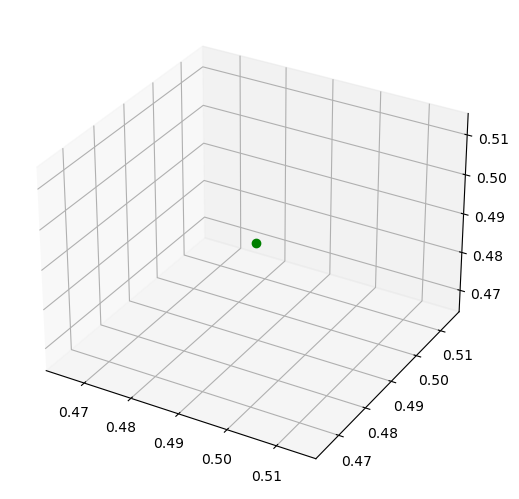

In [161]:
# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure()
ax = Axes3D(fig)
dotsEgo = ax.plot(dataSet[0][0], dataSet[1][0], dataSet[2][0], 'go')[0] # For scatter plot
x=np.linspace(0, 45, numDataPoints)